In [1]:
import numpy as np
import pyemma
import matplotlib
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import pyemma.coordinates as coord
import math
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)
plt.rc('text', usetex='True')
plt.rc('font', family='serif')

In [2]:
def filter(f, stride):
    for i, line in enumerate(f):
        if (not i%stride):
            yield line
            
def plotHistogram(trajs, extent=2.5, resolution=0.01):
    X = np.arange(-extent, extent, 0.01)
    Y = np.arange(-extent, extent, 0.01)
    Zfull = np.zeros([X.shape[0]-1, X.shape[0]-1])
    for traj in trajs:
        hist = np.histogram2d(traj[:,0], traj[:,1], bins = [X, Y], normed=False)
        Zfull += hist[0]
    shape = [X[0], X[-1], Y[0], Y[-1]]
    cp = plt.contourf(Zfull, 100, cmap=plt.cm.hot, extent=shape)

In [3]:
#Load trajectories: cut out parts of trajectories that start in an entry state until they reach one of the exit states.
fname = '/srv/data/dibakma/MSMRD/modifiedLJ2D/clustering/reflectiveRing/BD/2DmodifiedLJmultipleTrajsLongR4sampling10.npy'
#innerTruncTrajs are used to discretize the inner part of the MSM domain by running the kmeans algorithm on this data
innerTruncTrajs = []
trajs = []
bathtoMSMs = []
MSMtobaths = []
trajAssignment = []
fileIndex = []
dimension = 2
interactionRadius = 2.08
exitRadius = 2.8
data = np.load(fname)
ntrajs = data.shape[1]/dimension
for i in range(0, ntrajs):
    traj = data[:,2*i:2*i+dimension]
    trajs.append(traj)
    abs = np.linalg.norm(traj, axis = 1)
    trajActive = False
    innerTrajActive = False
    for i in range(len(traj)):
        if not innerTrajActive:
            if (abs[i]<interactionRadius):
                #Start a new inner truncated trajectory
                innerTrajActive = True
                currentInnerTraj = [traj[i]]
        else:
            if abs[i] > interactionRadius:
                innerTrajActive = False
                currentInnerTraj.append(traj[i])
                innerTruncTrajs.append(np.array(currentInnerTraj))
            else:
                currentInnerTraj.append(traj[i])

In [30]:
#Discretize trajectories: use milestoning for the exit states and clustering inside
NCenters = 30
clustering = pyemma.coordinates.cluster_kmeans(innerTruncTrajs, k=NCenters, max_iter = 10000)

18-02-17 01:46:38 pyemma.coordinates.clustering.kmeans.KmeansClustering[1] INFO     Cluster centers converged after 5 steps.


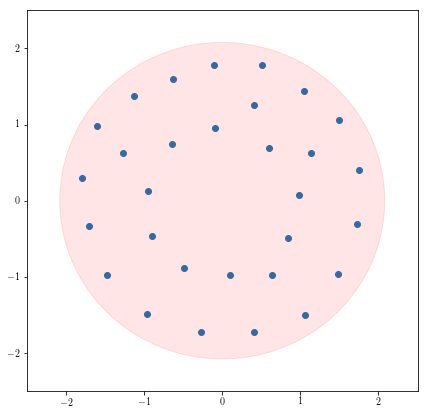

In [31]:
#Look at the output of the clustering algorithm just to make sure nothing weird happened
cc = clustering.clustercenters
fig, ax = plt.subplots()
domain  = plt.Circle((0, 0), interactionRadius, color='r', alpha=0.1)
plt.xlim((-2.5,2.5))
plt.ylim((-2.5,2.5))
ax.scatter(cc[:,0], cc[:,1])
ax.add_artist(domain)

In [32]:
innerDTraj = clustering.dtrajs

(array([ -200.,     0.,   200.,   400.,   600.,   800.,  1000.,  1200.]),
 <a list of 8 Text yticklabel objects>)

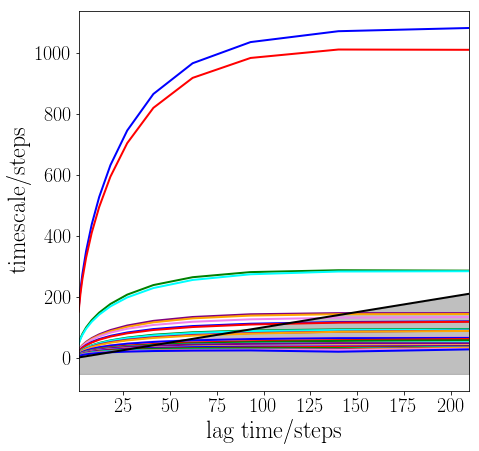

In [33]:
innerIts = pyemma.msm.its(innerDTraj, lags = 300)
mplt.plot_implied_timescales(innerIts, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [38]:
rCluster = np.linalg.norm(clustering.clustercenters, axis = 1)
volPerCluster = np.pi*np.power(interactionRadius,2)/float(NCenters)
print np.amax(rCluster)
print volPerCluster

1.88048
0.45305954855


In [39]:
#discretize trajectory: use two additional rings of states for entry and exit states
#cluster volume should be on the same order of magnitute as for the internal states
NangularPartitions = 15
dTrajs = []
Ren = 2.6
Rbath = 3.0
RouterBath = 3.4
volumeInnerPartition = np.pi*(Ren**2 - interactionRadius**2)/float(NangularPartitions)
volumeOuterPartition = np.pi*(Rbath**2 - Ren**2)/float(NangularPartitions)
print volumeInnerPartition, volumeOuterPartition
for traj in trajs:
    dTraj = []#np.zeros(len(traj), dtype=int)
    radius = np.linalg.norm(traj, axis=1)
    for i in range(0, len(traj)):
        if radius[i]<interactionRadius:
            dTraj.append(clustering.assign(np.array([traj[i]]))[0])
        elif radius[i]<Ren:
            theta = np.arctan2(traj[i,0], traj[i,1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = math.floor(theta/(2*np.pi)*NangularPartitions)
            assert(angularState < NangularPartitions)
            dTraj.append(NCenters + angularState)
        elif radius[i]<Rbath:
            theta = np.arctan2(traj[i,0], traj[i,1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = math.floor(theta/(2*np.pi)*NangularPartitions)
            assert(angularState < NangularPartitions)
            dTraj.append(NCenters + NangularPartitions + angularState)
        elif radius[i] < RouterBath:
            theta = np.arctan2(traj[i,0], traj[i,1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = math.floor(theta/(2*np.pi)*NangularPartitions)
            assert(angularState < NangularPartitions)
            dTraj.append(NCenters + 2*NangularPartitions + angularState)
        else:
            continue
    dTrajs.append(np.array(dTraj, dtype=int))

0.509691992118 0.469144502936


In [40]:
for dTraj in dTrajs:
    print dTraj[-1]
    if dTraj[-1] != NCenters + 2*NangularPartitions:
        print 'found one!'
print len(dTrajs)

37
found one!
25
found one!
43
found one!
29
found one!
64
found one!
24
found one!
7
found one!
40
found one!
54
found one!
39
found one!
10


In [36]:
print dTrajs

[array([44, 44, 45, ..., 44, 44, 44]), array([48, 48, 48, ..., 25, 25, 25]), array([51, 51, 51, ..., 56, 56, 56]), array([55, 55, 55, ..., 29, 29, 29]), array([58, 58, 58, ..., 98, 98, 98]), array([31, 31, 31, ..., 24, 24, 24]), array([34, 34, 34, ...,  7,  7,  7]), array([38, 38, 38, ..., 51, 51, 51]), array([41, 41, 41, ..., 78, 78, 78]), array([45, 45, 45, ..., 49, 49, 49])]


(array([ -500.,     0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.]),
 <a list of 8 Text yticklabel objects>)

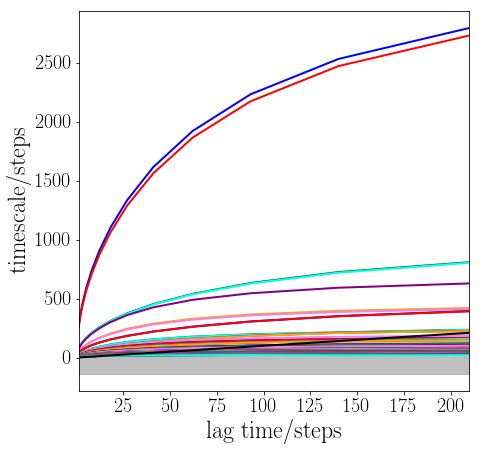

In [41]:
fullIts = pyemma.msm.its(dTrajs[:-1], lags = 300)
mplt.plot_implied_timescales(fullIts, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [15]:
M = pyemma.msm.estimate_markov_model(dTrajs, 50, reversible=True)

30 90
(180, 180)


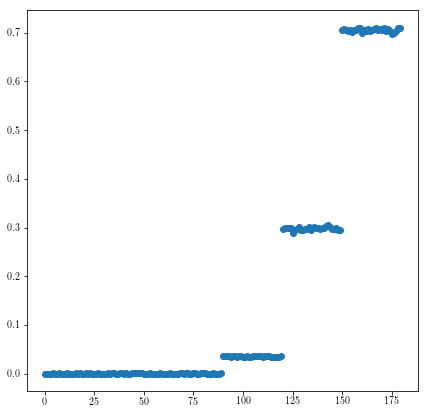

In [16]:
T = M.transition_matrix
plt.plot(np.sum(T[:,-NangularPartitions:], axis=1), 'o')
print NangularPartitions, NCenters
print T.shape

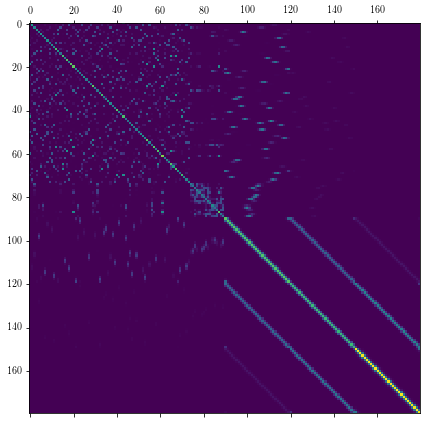

In [17]:
plt.matshow(T)

In [23]:
#Manually set transition probabilities form inner to bath statesto zero and renormalize
for i in range(0, NCenters):
    T[i,-NangularPartitions:] = 0
    T[i, :] /= np.sum(T[i,:])
print np.allclose(np.sum(T, axis=1), 1)

True


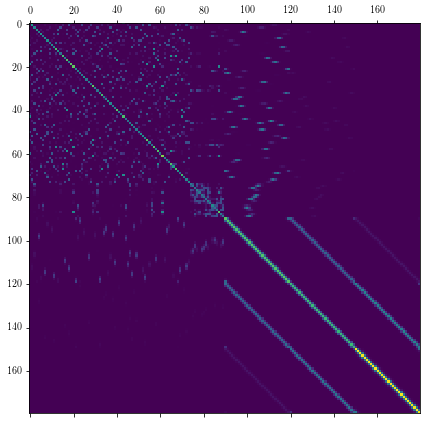

In [24]:
plt.matshow(T)

30 90
(180, 180)


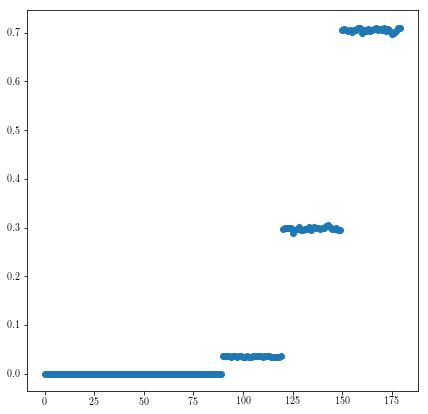

In [25]:
T = M.transition_matrix
plt.plot(np.sum(T[:,-NangularPartitions:], axis=1), 'o')
print NangularPartitions, NCenters
print T.shape

In [26]:
#resum all exit to states to obtain a smaller matrix
NreducedStates = NCenters + 2*NangularPartitions + 1
Trefined = np.zeros([NreducedStates, NreducedStates ])
for i in range(NreducedStates - 1):
    Trefined[i,:] = T[i,:NreducedStates]
    Trefined[i,NreducedStates-1] = np.sum(T[i,-NangularPartitions:])

30 90
(180, 180)


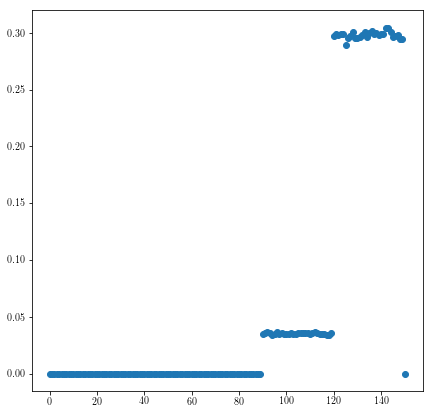

In [27]:
T = M.transition_matrix
plt.plot(Trefined[:,-1], 'o')
print NangularPartitions, NCenters
print T.shape

In [28]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters
parameters = {}
parameters['interactionRadius'] = interactionRadius
parameters['entryRadius'] = Ren
parameters['bathRadius'] = Rbath
parameters['outerBathRadius'] = RouterBath
parameters['NCenters'] = NCenters
parameters['NangularPartitions'] = NangularPartitions
parameters['lagtime'] = 5
model = MSMmodel(Trefined, clustering.clustercenters, parameters)

In [29]:
import pickle
pickle.dump(model, open('../data/predefinedCenters_90states_lag5_exitPartition.p', 'wb'))

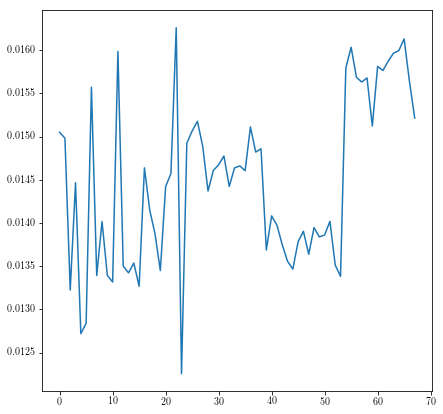

In [26]:
plt.plot(M.stationary_distribution[:-1])

In [117]:
print len(truncTrajs)
totalLength = 0
for t in truncTrajs:
    totalLength += len(t)
print totalLength/10.
print len(truncTrajs)/(totalLength/10.)

32659
332857.5
0.0981170621062


In [78]:
#discretize most inner part of MSM region
innerdTrajs = clustering.dtrajs

getting output of KmeansClustering: 100% (143620/143620) [#########] eta 00:01 \

estimating MaximumLikelihoodMSM: 100% (9/9) [######################] eta 00:01 /

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.]),
 <a list of 7 Text yticklabel objects>)

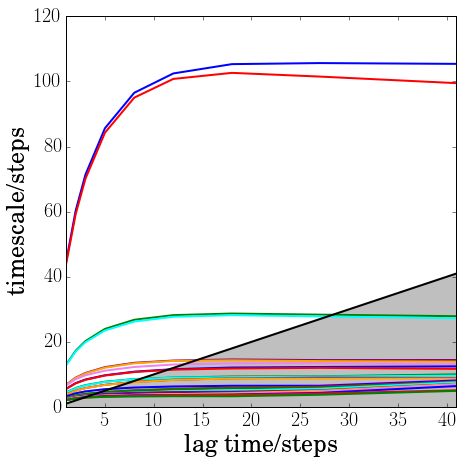

In [79]:
#adjust number of cluster centers in order to get to a good convergence at tau=10 and repeat (25 centers seems fine)
#the negative slope of the timescale plot might be due to trajectories being shorter than the respective lag time
innerIts = pyemma.msm.its(innerdTrajs, lags = 50)
mplt.plot_implied_timescales(innerIts, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [81]:
#compute count matrix for given lagtime
#if trajectory is shorter than lagtime, add the exit 
#use "sliding window" method for bettter data efficiency
def computeCountMatrix(dTrajs, lagtime):
    NStates = NCenters + NangularPartitions
    C = np.zeros([NCenters, NStates])
    for dTraj in dTrajs:
        if len(dTraj) < lagtime:
            C[dTraj[0], dTraj[-1]] += 1
            continue
        for i in range(len(dTraj) - lagtime):
            C[dTraj[i], dTraj[i+lagtime]] += 1
    return C

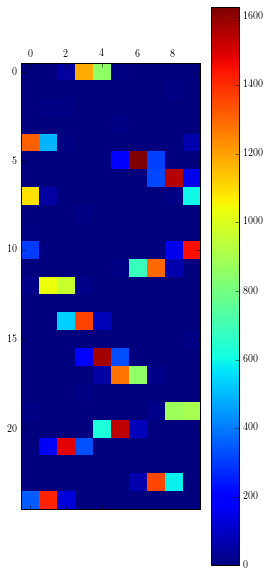

In [105]:
C = computeCountMatrix(dTrajs, 10)
#plt.matshow(C)
plt.matshow(C[:,NCenters:])
plt.colorbar()

(100,) (101,)


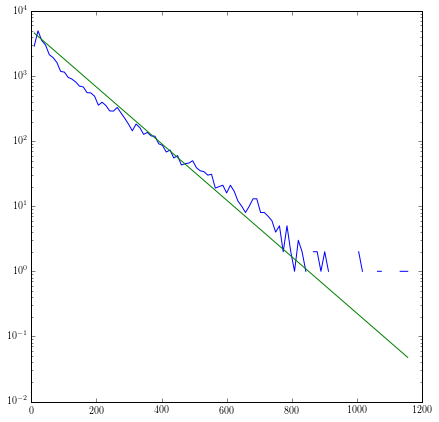

In [146]:
lengths = np.zeros(len(truncTrajs))
for i in range(len(truncTrajs)):
    lengths[i] = len(truncTrajs[i])
hist = np.histogram(lengths, bins= 100, normed=False)
print hist[0].shape, hist[1].shape
x = (hist[1][1:]+hist[1][:-1])/2.
plt.semilogy(x, hist[0])
hist[1][-2]
plt.plot(x, np.exp(-x/100)*5000)

In [83]:
import msmtools.estimation as msmest
def computeInnerMSM(C, NCenters):
    innerC = C[:, :NCenters]
    T = msmest.transition_matrix(C = innerC, reversible=True)
    msm = pyemma.msm.markov_model(T)
    return msm

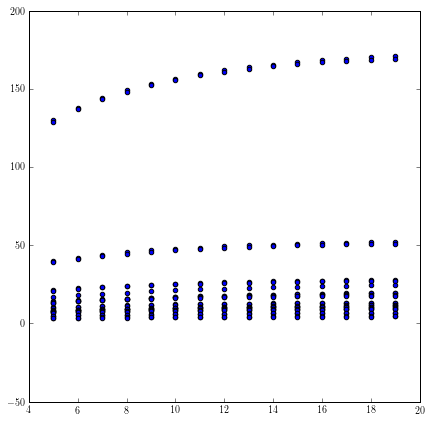

In [85]:
#Check inner MSM for convergence at the given lagtime
#This includes  the milestoning in the inner part, buyt excludes exti states
for lag in range(5, 20):
    C = computeCountMatrix(dTrajs, lag)
    innerMSM = computeInnerMSM(C, NCenters)
    timescales = innerMSM.timescales()
    plt.scatter([lag] * len(timescales), timescales*lag)

In [111]:
#For the transition matrix, we use a reversible estimator for the inner part of the MSM.
#Since the exit states have no possibility to come back, 
#we estimate the transition probability by counting and normalizing.
#Both are combined using the weight given from the count matrix.
def computeTransitionMatrix(dTrajs, lag, NCneters):
    C = computeCountMatrix(dTrajs, lag)
    innerMSM = computeInnerMSM(C, NCenters)
    transitionMatrix = np.zeros_like(C, dtype=float)
    for i in range(NCenters):
        innerW = np.sum(C[i,:NCenters]) / np.sum(C[i,:])
        outerW = 1. / np.sum(C[i,:])
        transitionMatrix[i,:NCenters] = innerMSM.transition_matrix[i,:] * innerW
        transitionMatrix[i,NCenters:] = C[i,NCenters:] * outerW
    return transitionMatrix

def computeTransitionMatrixTrivial(dTrajs, lag):
    C = computeCountMatrix(dTrajs, lag)
    transitionMatrix = np.zeros_like(C, dtype=float)
    for i in range(NCenters):
        weight = 1. / np.sum(C[i,:])
        transitionMatrix[i,:] = C[i,:]*weight
    return transitionMatrix

In [106]:
print innerW

NameError: name 'innerW' is not defined

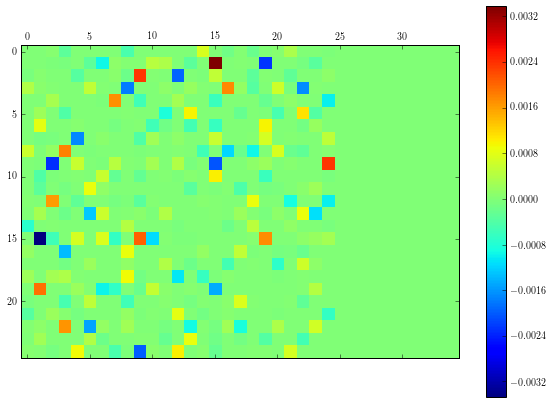

In [112]:
finalT = computeTransitionMatrix(dTrajs, 10, NCenters)
trivialT = computeTransitionMatrixTrivial(dTrajs, 10)
plt.matshow(finalT - trivialT)
plt.colorbar()

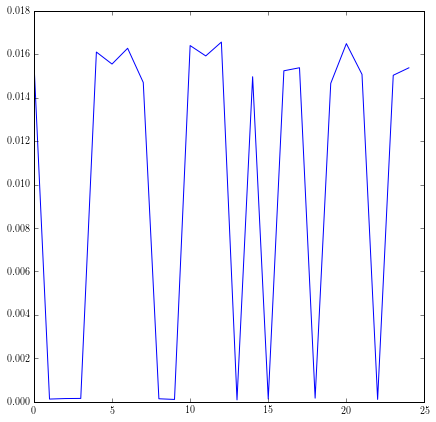

In [92]:
plt.plot(np.sum(finalT[:,NCenters:], axis = 1))

In [96]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters
parameters = {}
parameters['entryRadius'] = entryRadius
parameters['exitRadius'] = exitRadius
parameters['NCenters'] = NCenters
parameters['NangularPartitions'] = NangularPartitions
parameters['lagtime'] = 10
model = MSMmodel(finalT, clustering.clustercenters, parameters)

In [98]:
import pickle
pickle.dump(model, open('../data/entryToExit_100states_lag10.p', 'wb'))